In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Palatino'
plt.rcParams['figure.figsize'] = [3,3]
plt.rcParams['figure.dpi'] = 200
sns.set_style("white")
sns.set_palette("Set2")

max_len = 128

In [3]:
mean_path = "/homefs/home/lux70/plaid_cached_tensors/cath/esmfold/subset_5000_nov28/channel_mean.pkl.npy"
std_path = "/homefs/home/lux70/plaid_cached_tensors/cath/esmfold/subset_5000_nov28/channel_std.pkl.npy"

means = np.load(mean_path, allow_pickle=True)

np.sort(means)
len(means[np.abs(means) > 20])
idxs = np.arange(len(means))
OUTLIER_CHANNELS = idxs[np.abs(means) > 20]

# print(np.argsort(chan_means)[-3:])
# print(np.argsort(chan_means)[:3])

print(OUTLIER_CHANNELS)

[ 37 274 641]


In [4]:
print(means.max(), means.min())

2236.9282 -685.75354


Text(0.5, 0, 'Activations (log-scale)')

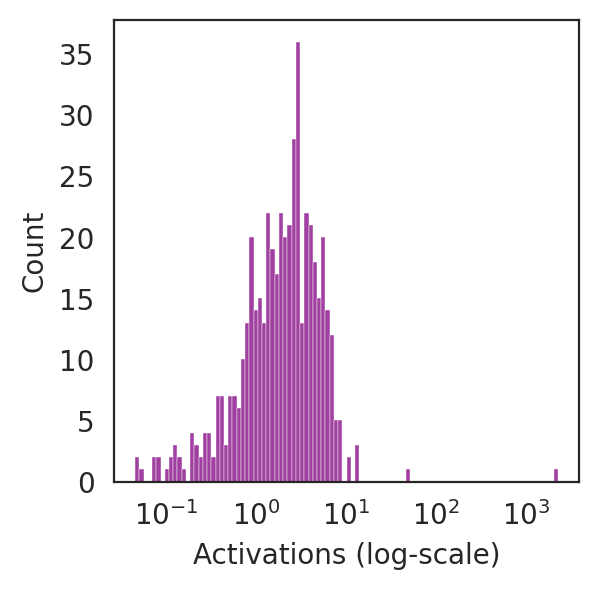

In [5]:
_ = sns.histplot(means,bins=100,log_scale=True,color="purple")
plt.xlabel("Activations (log-scale)")

In [6]:
print(means.max(), means.min())
print(np.sort(means)[:10])
print(np.sort(means)[-10:])
print(np.argsort(means)[-10:])
print(np.argsort(means)[:10])

print(len(means[np.abs(means) > 20]))
idxs = np.argsort(means)
print(idxs[np.abs(means) > 20])
# OUTLIER_CHANNELS = [274, 641, 37]

2236.9282 -685.75354
[-685.75354   -18.101856  -15.315539  -14.587975  -13.071007  -12.679328
  -11.683959  -11.223595  -10.450609  -10.008281]
[   8.418381    8.490976    8.772289   10.126271   10.530647   13.367767
   13.758203   13.80922    47.51916  2236.9282  ]
[836 666 459 209 492 722 203 451 641 274]
[ 37 243 326 163 337 772 673 928 122 342]
3
[1019  965  715]


# Remove outlier channels
Also see `09_examine_latent_dim.ipynb`.

In [9]:
clean_means = means[~(np.abs(means) > 20)]
print(len(clean_means))

1021


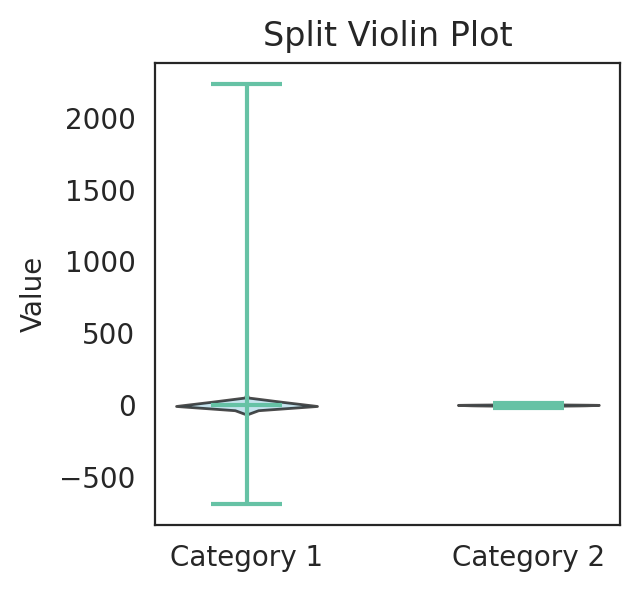

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Create sample data with different lengths
data1 = means
data2 = clean_means

# Create a figure and axis
fig, ax = plt.subplots()

# Create the split violin plot
violin_parts = ax.violinplot([data1, data2], positions=[0, 1], showmeans=True, showextrema=True)

# Customize the violin plot
for part in violin_parts['bodies']:
    part.set_facecolor('lightblue')
    part.set_edgecolor('black')
    part.set_alpha(0.7)

# Set the labels and title
ax.set_xticks([0, 1])
ax.set_xticklabels(['Category 1', 'Category 2'])
ax.set_ylabel('Value')
ax.set_title('Split Violin Plot')

# Display the plot
plt.show()

Text(0.5, 0, 'Activations')

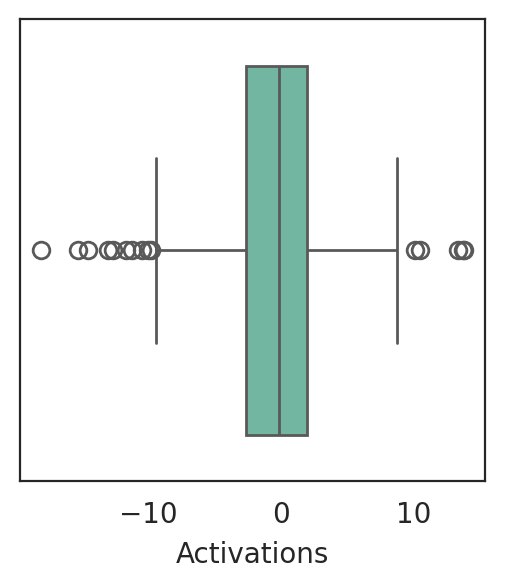

In [11]:
sns.boxplot(x=clean_means)
plt.xlabel("Activations")

Text(0.5, 0, 'Activations')

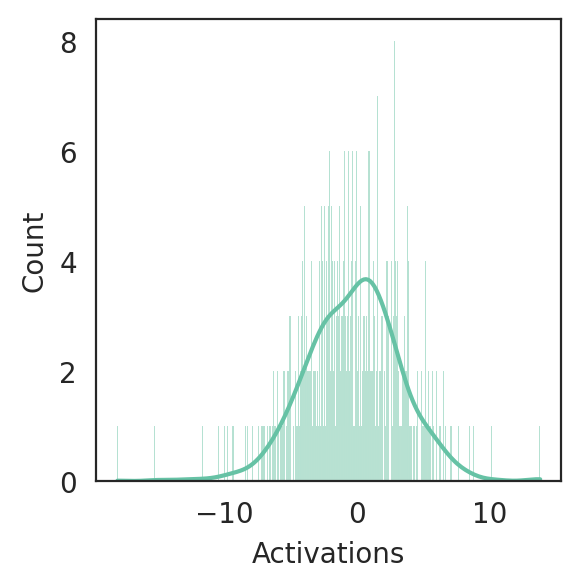

In [12]:
sns.histplot(x=clean_means,bins=len(clean_means), kde=True)
plt.xlabel("Activations")

# Visualize Structure Prediction

In [14]:
from plaid.esmfold import esmfold_v1
esmfold = esmfold_v1()

import torch
device = torch.device("cuda")
esmfold = esmfold.to(device)
esmfold = esmfold.eval().requires_grad_(False)

In [24]:
from plaid.datasets import CATHShardedDataModule
dm = CATHShardedDataModule(
    shard_dir="/data/lux70/data/cath/shards/",
    seq_len = 128,
    storage_type = "hdf5",
)
dm.setup()
batch = next(iter(dm.val_dataloader()))

In [25]:
from plaid.esmfold.misc import batch_encode_sequences
# x, sequences, cath_ids = tuple(map(lambda x: x[:5], batch))

x, sequences, cath_ids = batch
x_zeros = deepcopy(x)
original_cath_structures = []
for cath_id in cath_ids:
    with open(f"/data/lux70/data/cath/dompdb/{cath_id}") as f:
        original_cath_structures.append(f.read())

sequences = [s[:max_len] for s in sequences]
aatype, mask, residx, linker_mask, chain_index_list  = batch_encode_sequences(sequences)
x_zeros[:, :, OUTLIER_CHANNELS] = 0
x, mask, x_zeros, aatype, residx = tuple(map(lambda x: x.to(device), (x, mask, x_zeros, aatype, residx)))

out = esmfold.infer(sequences)
out.keys()

dict_keys(['frames', 'sidechain_frames', 'unnormalized_angles', 'angles', 'positions', 'states', 'single', 'sm_s', 'sm_z', 's_s', 's_z', 'distogram_logits', 'lm_logits', 'aatype', 'atom14_atom_exists', 'residx_atom14_to_atom37', 'residx_atom37_to_atom14', 'atom37_atom_exists', 'residue_index', 'lddt_head', 'plddt', 'ptm_logits', 'ptm', 'aligned_confidence_probs', 'predicted_aligned_error', 'max_predicted_aligned_error', 'mean_plddt', 'chain_index'])

In [26]:
from plaid.esmfold import output_to_pdb
esmfold_gt = output_to_pdb(out)

In [27]:
x.shape

torch.Size([32, 128, 1024])

In [28]:
orig_plddt = out['plddt'].mean(dim=(1,2)).cpu().numpy()

# Structure from sequence vs. from latent

In [29]:
from plaid.esmfold import make_s_z_0
z = make_s_z_0(x).to(device)

In [30]:
structure_from_latent = esmfold.folding_trunk(x, z, aatype, residx, mask, num_recycles=4)

In [31]:
structure_from_latent_pdb = output_to_pdb(structure_from_latent)

<Axes: ylabel='Count'>

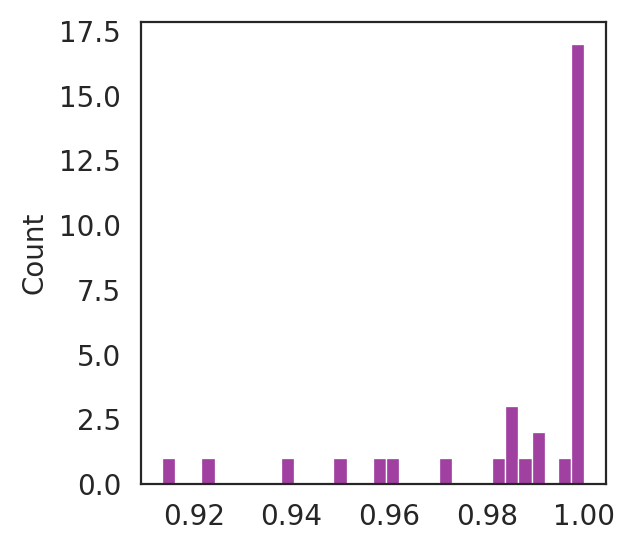

In [32]:
from plaid.evaluation import run_tmalign
no_surgery_tmscores = [run_tmalign(from_seq, from_latent) for (from_seq, from_latent) in zip(esmfold_gt, structure_from_latent_pdb)]
sns.histplot(no_surgery_tmscores, bins=len(no_surgery_tmscores), color='purple')

<Axes: ylabel='Count'>

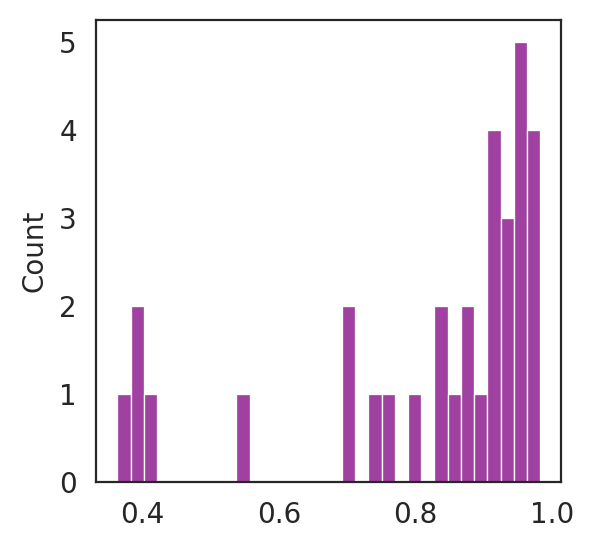

In [335]:
from plaid.evaluation import run_tmalign
orig_tmscores = [run_tmalign(original, from_latent) for (original, from_latent) in zip(original_cath_structures, structure_from_latent_pdb)]
sns.histplot(orig_tmscores, bins=len(orig_tmscores), color='purple')

In [33]:
# import py3Dmol

# for i in range(10):
#     view = py3Dmol.view(width=400, height=300)
#     view.addModelsAsFrames(esmfold_gt[i])
#     view.addModelsAsFrames(structure_from_latent_pdb[i])
#     view.addModelsAsFrames(original_cath_structures[i])
#     view.setBackgroundColor("white")
#     view.setStyle({"model": 0}, {"cartoon": {"color": "red", "transparency": 0.5}})
#     view.setStyle({"model": 1}, {"cartoon": {"color": "green", "transparency": 0.5}})
#     view.setStyle({"model": 2}, {"cartoon": {"color": "gray", "transparency": 0.5}})
#     view.zoomTo()
#     view.show()


# Zeroed Out Channels

In [34]:
from plaid.proteins import LatentToSequence, LatentToStructure

latent2seq = LatentToSequence().to(device)
latent2struct = LatentToStructure(esmfold).to(device)

outputs = latent2struct.to_structure(x_zeros, sequences)

(0.0, 100.0)

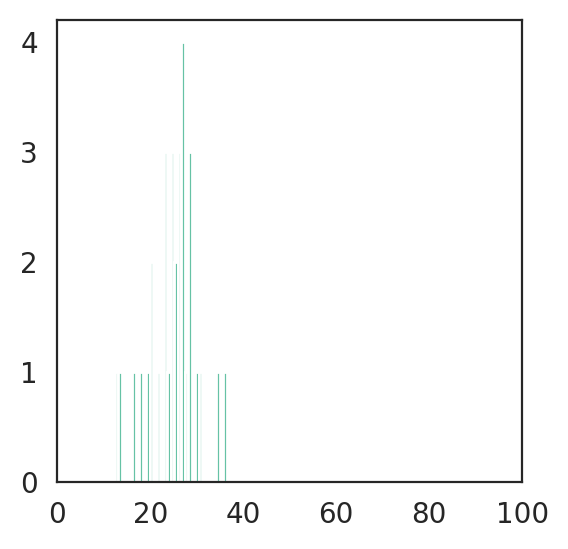

In [45]:
zeroed_plddts = outputs[1]['plddt'].mean(dim=(1,2))
plt.hist(zeroed_plddts, bins=len(zeroed_plddts))
plt.xlim(0, 100)

(0.0, 1.0)

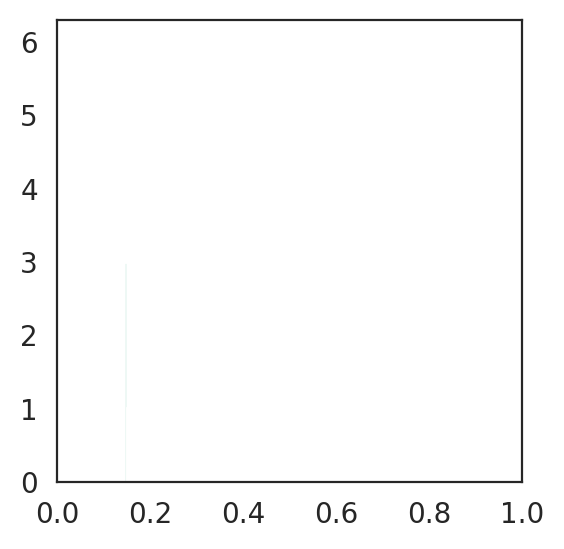

In [47]:
zeroed_out_pdb_structures = outputs[0]
#tmscore_zeroed = [run_tmalign(from_latent, from_zeroed_latent) for (from_latent, from_zeroed_latent) in zip(structure_from_latent_pdb, zeroed_out_pdb_structures)]
tmscore_zeroed = [run_tmalign(gt, from_zeroed_latent) for (gt, from_zeroed_latent) in zip(structure_from_latent_pdb, zeroed_out_pdb_structures)]

plt.hist(tmscore_zeroed, bins=20)
plt.xlim(0, 1)

In [37]:
print(np.mean(tmscore_zeroed))
print(len(tmscore_zeroed))

0.1298053125
32


In [40]:
print(len(no_surgery_tmscores), len(tmscore_zeroed))

32 32


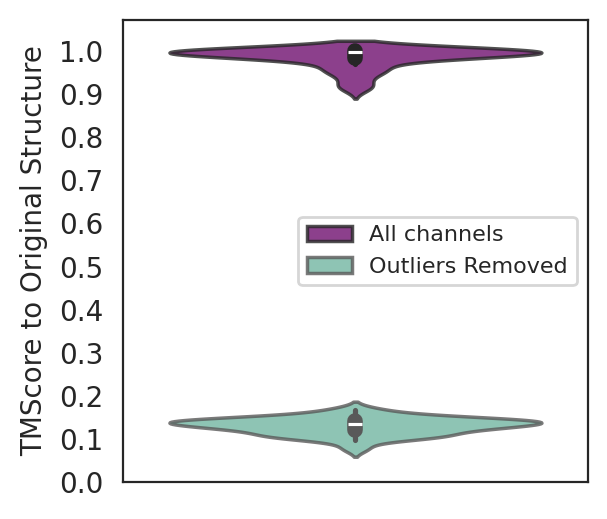

In [62]:
sns.violinplot(no_surgery_tmscores, color='purple', label="All channels",alpha=0.8)
sns.violinplot(tmscore_zeroed, label="Outliers Removed",alpha=0.8)

plt.ylabel("TMScore to Original Structure")
plt.legend(fontsize=8)
_ = plt.yticks(np.arange(0,1.10,0.1))

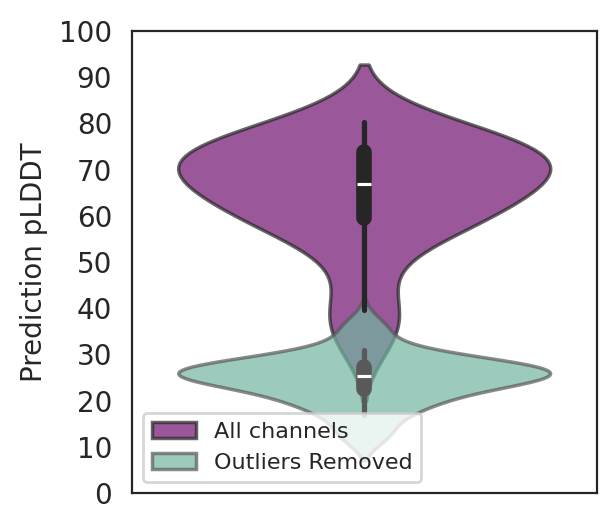

In [66]:
sns.violinplot(orig_plddt, color='purple', label="All channels", alpha=0.7)
sns.violinplot(zeroed_plddts, label="Outliers Removed",alpha=0.7)

plt.ylabel("Prediction pLDDT")
plt.legend(fontsize=8,loc="lower left")
_ = plt.yticks(np.arange(0,110,10))

In [330]:
# from plaid.utils import write_pdb_to_disk

# for i, pdb in enumerate(structure_from_latent_pdb):
#     write_pdb_to_disk(pdb, f"/data/lux70/plaid/artifacts/zero_out_massive_activations/original{i}.pdb")
    
# for i, pdb in enumerate(zeroed_out_pdb_structures):
#     write_pdb_to_disk(pdb, f"/data/lux70/plaid/artifacts/zero_out_massive_activations/zeroed{i}.pdb")

# Visualize Effects of Zeroing Out

In [426]:
import py3Dmol

for i in range(10):
    view = py3Dmol.view(width=800, height=800)
    view.addModelsAsFrames(esmfold_gt[i])
    view.addModelsAsFrames(zeroed_out_pdb_structures[i])
    view.setBackgroundColor("white")
   # view.addModelsAsFrames(original_cath_structures[i])
    view.setStyle({"model": 0}, {"cartoon": {"color": "#BB74C3", "transparency": 0.5}})
    view.setStyle({"model": 1}, {"cartoon": {"color": "#37AB97", "transparency": 0.5}})
   # view.setStyle({"model": 2}, {"cartoon": {"color": "gray", "transparency": 0.5}})
    view.zoomTo()
    view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.